# EDA

In [1]:
!pip install pymysql
!pip install meteostat
# !pip install SQLAlchemy==1.4.48
# !pip install SQLAlchemy==2.0
!pip install SQLAlchemy

In [2]:
import pandas as pd
import numpy as np

import datetime

from meteostat import Point, Daily
import sqlalchemy as sa

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno

******

************

## 1. Consulta a la base de datos

In [ ]:
class DatabaseConnection:

    # Información necesaria para establecer la conexión a la BBDD
    def __init__(self, password,
                 dialect = "mysql",
                 driver = "pymysql",
                 username = "",
                 host = "database-1.cjyy8w6ya3fr.eu-north-1.rds.amazonaws.com",
                 port = "3306",
                 database = "sandbox"):

        self.__password = password
        connection_string = f"{dialect}+{driver}://{username}:{password}@{host}:{port}/{database}"
        self.engine = sa.create_engine(connection_string)

    # Función cuyo cometido es consultar una query a la BBDD y devolverla como un dataframe de Pandas
    def query_to_df(self, query):
        with self.engine.connect() as conn:
            df = pd.read_sql_query(query, conn)
            return df


# Query a consultar. Cambio de nombre de fechaVenta.
# IMP: se omiten las columnas irrelevantes -> 'in_fecha_estudio' y 'tipo'
query_daily_and_top = """
SELECT familia,
articulo,
fechaVenta AS fecha_venta,
festivo,
precio,
cantidad,
importe,
orden_articulo_familia

FROM sandbox.EHR_ventas_diarias_estudio
"""

# Instaciar la clase con la contraseña de la BBDD
database = DatabaseConnection("")

# Consultar la query anterior y devolverla como un dataframe de Pandas
ventas = database.query_to_df(query_daily_and_top)

# Convertir 'fecha_venta' a un formato de fecha y 'articulo' a entero
ventas = (
           ventas.assign(fecha_venta = pd.to_datetime(ventas["fecha_venta"]))
                 .astype({"articulo": int})
        )

ventas

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia
0,BOLLERIA,3880,2021-05-01,None,2.591000,285.000,738.434998,3
1,BOLLERIA,3960,2021-05-01,None,2.318000,402.000,931.835995,1
2,BOLLERIA,5803,2021-05-01,None,2.727000,237.000,646.298981,5
3,BOLLERIA,6286,2021-05-01,None,3.136000,165.000,517.440006,4
4,BOLLERIA,6425,2021-05-01,None,31.364000,31.725,995.022083,2
...,...,...,...,...,...,...,...,...
10317,PASTELERIA,5403,2023-04-30,None,40.772999,28.500,1162.031006,2
10318,PASTELERIA,5404,2023-04-30,None,43.500000,35.100,1526.850006,1
10319,PASTELERIA,6451,2023-04-30,None,43.500000,27.000,1174.500000,4
10320,PASTELERIA,6523,2023-04-30,None,40.772999,9.000,366.957001,3


******

***************

## 2. Consulta a [meteostat API](https://dev.meteostat.net/python/daily.html)

Variables que se obtienen:

- **tavg** -> The average air temperature in °C
- **tmin** -> The minimum air temperature in °C
- **tmax** -> The maximum air temperature in °C
- **prcp** -> The daily precipitation total in mm
- **wdir** -> The average wind direction in degrees (°)
- **wspd** -> The average wind speed in km/h
- **pres** -> The average sea-level air pressure in hPa

In [ ]:
class DailyWeatherData:

    # Localización de la tienda de la Panadería Salvador Echeverría


    # Columnas identificadas como importantes
    IMP_COLUMNS = ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']

    # Definición del horizonte temporal de la consulta a la API
    def __init__(self, start, end = datetime.datetime.now()):
        self.start = start
        self.end = end

    # Se establece que la consulta será diaria, se seleccionan todas las columnas imps y se añade un suff.
    def get_weather_data(self):
        daily_data = Daily(self.ECHEVERRIA_SHOP, self.start, self.end)
        data = daily_data.fetch()
        return data[self.IMP_COLUMNS].add_suffix('_w').reset_index()

In [5]:
# Fecha en la que comienza el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
start = ventas["fecha_venta"].min()

# Fecha en la que termina el conjunto de datos de ventas
# Se puede definir también en este formato -> Ej: datetime.datetime(2017, 1, 1)
end = ventas["fecha_venta"].max()

# Instancia la clase con el horizonte temporal a consultar
weather_query = DailyWeatherData(start, end)

# Obtener la info del tiempo del horizonte temporal consultado
weather = weather_query.get_weather_data()

weather

,time,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
0,2021-05-01,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0
1,2021-05-02,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
2,2021-05-03,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7
3,2021-05-04,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0
4,2021-05-05,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5
...,...,...,...,...,...,...,...,...
725,2023-04-26,20.3,15.5,26.0,0.0,<NA>,10.6,1014.0
726,2023-04-27,19.1,15.0,24.5,0.0,<NA>,9.9,1015.1
727,2023-04-28,20.8,16.6,26.7,0.0,<NA>,14.3,1015.2
728,2023-04-29,25.6,18.7,34.3,0.0,<NA>,16.9,1015.4


In [6]:
# Solo dos días tienen valores nulos en 3 de 7 columnas
weather.isnull().sum()

time        0
tavg_w      0
tmin_w      0
tmax_w      0
prcp_w      7
wdir_w    730
wspd_w      0
pres_w      0
dtype: int64

In [7]:
weather.to_excel("20250703 variables meteorologicas.xlsx", "Data", index = False)

******

*********************

## 3. Join -> Datos de ventas y del tiempo

In [8]:
# Join del conjunto de datos de ventas y del tiempo por medio de la columna de fecha
df = pd.merge(ventas, weather,
              left_on=["fecha_venta"], right_on=["time"],
              how="inner").drop("time", axis=1)

# Ordenar el dataframe
df.sort_values(["articulo", "fecha_venta"], inplace = True)

df.head(5)

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
3646,PANADERIA,417,2021-05-01,None,4.038,72.0,290.736004,5,17.2,11.9,22.8,0.0,<NA>,14.2,1014.0
3651,PANADERIA,417,2021-05-02,Día de la Madre,4.038,81.0,327.077995,5,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
3656,PANADERIA,417,2021-05-03,Día de la Cruz,4.038,90.0,363.419998,5,15.3,12.7,20.1,6.5,<NA>,9.7,1017.7
3661,PANADERIA,417,2021-05-04,None,4.038,84.0,339.192001,5,16.5,12.0,20.9,0.0,<NA>,12.1,1018.0
3666,PANADERIA,417,2021-05-05,None,4.038,84.0,339.192003,5,16.7,12.3,21.7,0.0,<NA>,13.8,1016.5


******

******

## 4. EDA

******

#### 4.1. Inspección inicial

Este apartado tiene como cometido comprender la estructura del conjunto de datos y ver posibles problemas de calidad que podrían afectar al análisis.

**Grupo de preguntas 1** (x minutos):

1. Describe que significa cada fila de nuestro conjunto de datos.

2. ¿Cuántos valores únicos hay en cada una de las variables? ¿Qué insight podrías observar al comparar los valores únicos de la variable "articulo" con los valores únicos de la variable "precio"?

3. ¿Cuántos valores nulos hay en cada una de las variables?

4. ¿Hay duplicados?

# 1.Describe que significa cada fila de nuestro conjunto de datos.
### cuanto se vende de cada articulo por dia



In [9]:
# 2
df.describe(include='all')

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
count,10322,10322.000000,10322,809,10322.000000,10322.000000,10322.000000,10322.000000,10322.0,10322.0,10322.0,10225.0,0.0,10322.0,10322.0
unique,3,NaN,NaN,26,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
top,PANADERIA,NaN,NaN,Feria de Málaga,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
freq,3650,NaN,NaN,99,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
mean,NaN,3945.385197,2022-04-29 14:56:20.275140608,NaN,15.398333,138.310118,462.617803,2.961538,19.373164,15.195786,24.894371,0.794455,<NA>,14.354524,1018.058555
min,NaN,417.000000,2021-05-01 00:00:00,NaN,0.865000,1.200000,9.000000,1.000000,7.3,1.1,13.3,0.0,<NA>,6.1,1004.4
25%,NaN,1043.000000,2021-10-28 00:00:00,NaN,2.591000,15.000000,288.000000,2.000000,14.5,10.8,19.6,0.0,<NA>,10.9,1014.5
50%,NaN,5403.000000,2022-04-29 00:00:00,NaN,3.545000,84.000000,405.059754,3.000000,19.3,14.6,24.7,0.0,<NA>,12.5,1017.3
75%,NaN,6286.000000,2022-10-29 00:00:00,NaN,34.091000,219.000000,569.453926,4.000000,23.9,20.1,29.6,0.0,<NA>,16.9,1021.0
max,NaN,6549.000000,2023-04-30 00:00:00,NaN,43.500000,1110.000000,3271.929962,5.000000,33.5,27.5,42.6,46.8,<NA>,46.5,1032.8


In [10]:
df['familia'] = df['familia'].astype(str)
df['festivo'] = df['festivo'].astype(str)

In [11]:
# 2
# La diferencia entre el número único de artículos y de precios muestra que los precios cambian a lo largo del tiempo
summary = (
    df.dtypes.to_frame("Tipo")
    .assign(Cardinalidad = df.nunique())
    .assign(Granularidad = df.nunique() / len(df) * 100)
    .assign(Nulos_Pct = df.isnull().sum() / len(df) * 100)
    # .assign(Max = df.dropna().apply(max))
    # .assign(Min = df.dropna().apply(min))
    # .sort_values(["Tipo"])
)

In [12]:
# Calcular máximos y mínimos por separado y unirlos
max_vals = df.max(numeric_only=False).rename("Max")
min_vals = df.min(numeric_only=False).rename("Min")

# Unir todo
summary = summary.join([max_vals, min_vals])



In [13]:
summary.sort_values("Tipo", key=lambda col: col.astype(str))

,Tipo,Cardinalidad,Granularidad,Nulos_Pct,Max,Min
tavg_w,Float64,200,1.937609,0.00000,33.5,7.3
tmin_w,Float64,212,2.053866,0.00000,27.5,1.1
tmax_w,Float64,220,2.131370,0.00000,42.6,13.3
prcp_w,Float64,58,0.561907,0.93974,46.8,0.0
wdir_w,Float64,0,0.000000,100.00000,<NA>,<NA>
wspd_w,Float64,196,1.898857,0.00000,46.5,6.1
pres_w,Float64,217,2.102306,0.00000,1032.8,1004.4
fecha_venta,datetime64[ns],730,7.072273,0.00000,2023-04-30 00:00:00,2021-05-01 00:00:00
precio,float64,45,0.435962,0.00000,43.5,0.865
cantidad,float64,1388,13.447006,0.00000,1110.0,1.2


<Axes: >

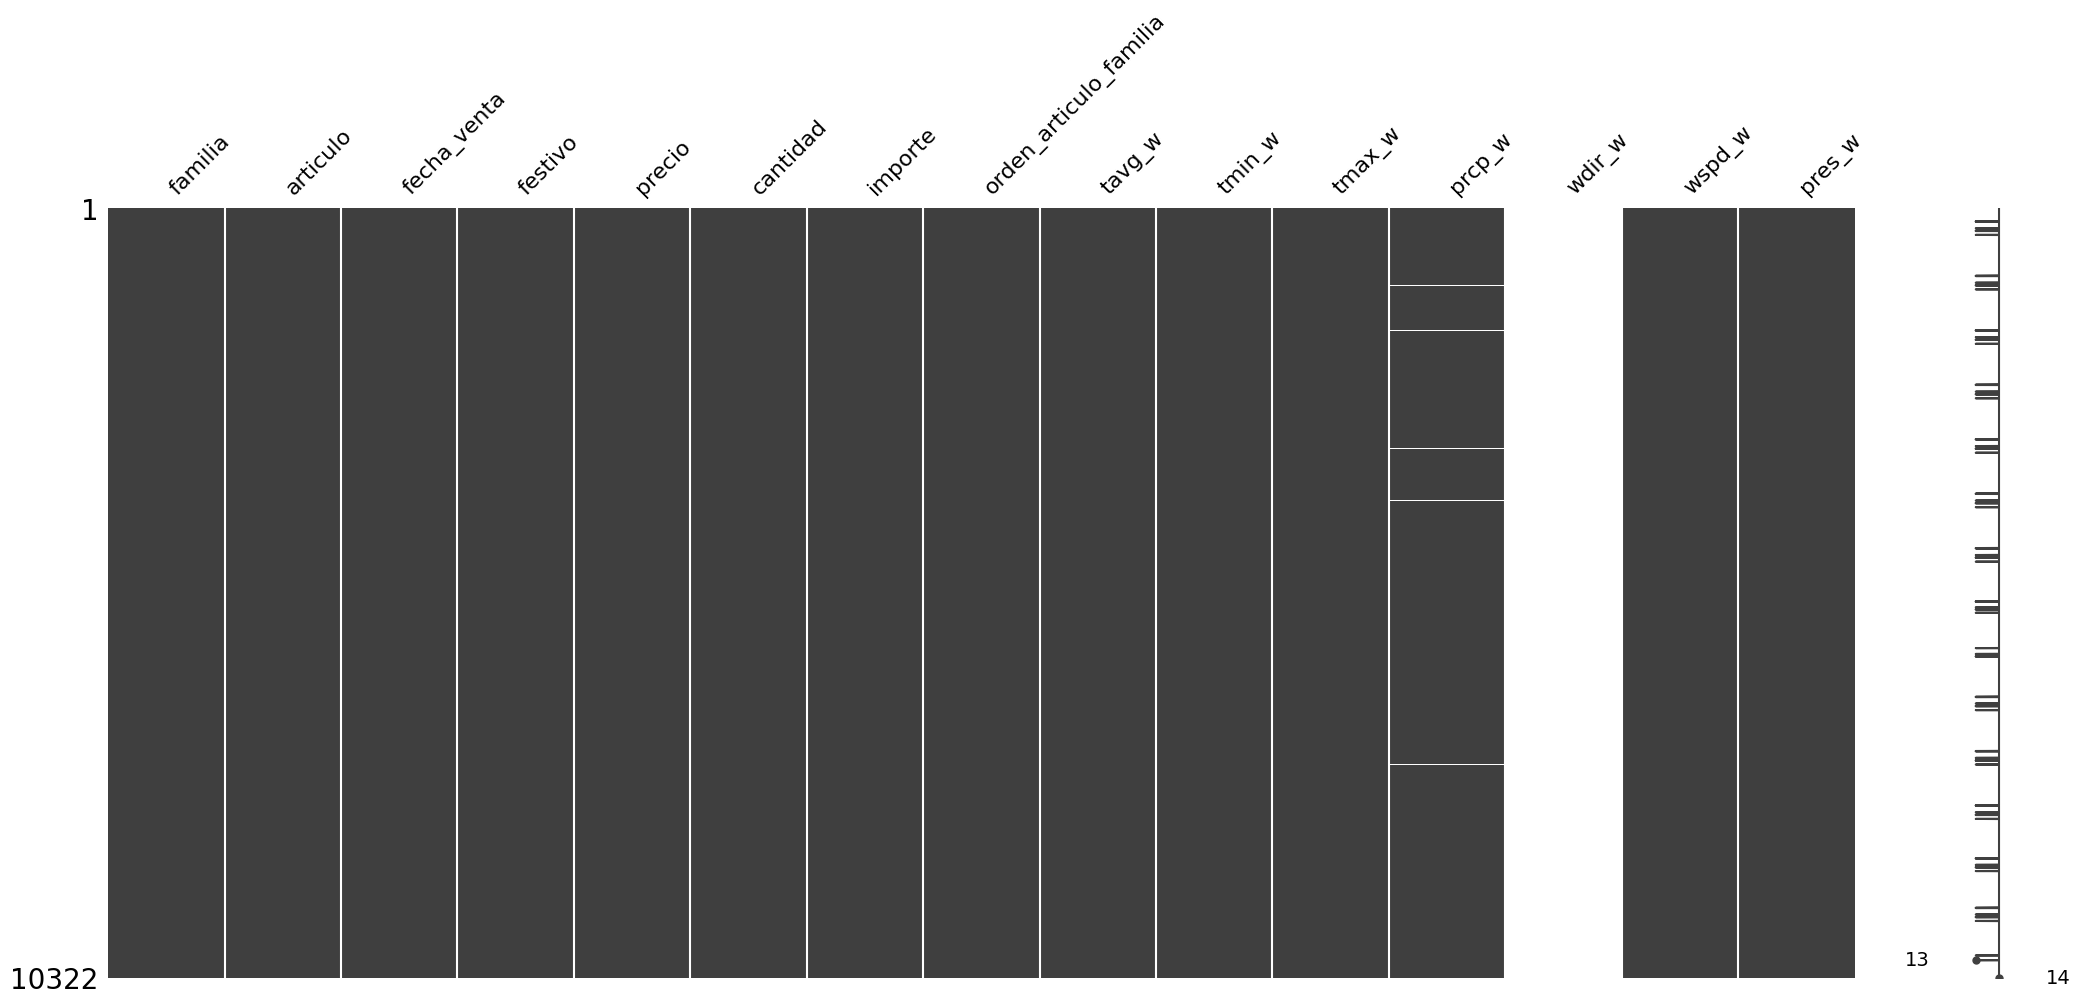

In [14]:
# 3
# Valores nulos

msno.matrix(df)

In [15]:
# 4
# Valores duplicados

df[df.duplicated(['fecha_venta', 'articulo'], keep=False)]
#df.drop_duplicates(['fecha_venta', 'articulo'])

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w


**Grupo de preguntas 2** (x minutos):

5. ¿Cuál es el rango de fechas de nuestro conjunto de datos? Si se divide por producto, ¿hay fechas faltantes? Crea un gráfico de evolución temporal para la variable "cantidad" que muestre el producto "6549".

6. Separando por producto, ¿hay outliers en la variable "cantidad"?

In [16]:
# 5
# Rango de fechas del conjunto de datos

min_date = df['fecha_venta'].min()
max_date = df['fecha_venta'].max()

print(f"El conjunto de datos contiene valores desde {min_date} hasta {max_date}. ",
      f"Lo que supone {max_date - min_date}")

El conjunto de datos contiene valores desde 2021-05-01 00:00:00 hasta 2023-04-30 00:00:00.  Lo que supone 729 days 00:00:00


In [17]:
# 5
# Fechas faltantes

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()
complete_range = pd.date_range(start=min_date, end=max_date, freq='D')

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    missing_dates = complete_range.difference(subset['fecha_venta'])

    print(family, "-> Articulo", article, "-> Fechas faltantes", len(missing_dates))

BOLLERIA -> Articulo 3960 -> Fechas faltantes 0
BOLLERIA -> Articulo 5803 -> Fechas faltantes 3
BOLLERIA -> Articulo 3880 -> Fechas faltantes 0
BOLLERIA -> Articulo 6286 -> Fechas faltantes 2
BOLLERIA -> Articulo 6425 -> Fechas faltantes 1
PANADERIA -> Articulo 1084 -> Fechas faltantes 0
PANADERIA -> Articulo 417 -> Fechas faltantes 0
PANADERIA -> Articulo 900 -> Fechas faltantes 0
PANADERIA -> Articulo 968 -> Fechas faltantes 0
PANADERIA -> Articulo 1043 -> Fechas faltantes 0
PASTELERIA -> Articulo 6451 -> Fechas faltantes 73
PASTELERIA -> Articulo 6549 -> Fechas faltantes 304
PASTELERIA -> Articulo 6523 -> Fechas faltantes 48
PASTELERIA -> Articulo 5403 -> Fechas faltantes 103
PASTELERIA -> Articulo 5404 -> Fechas faltantes 94


In [18]:
# 5
# Gráfico de la cantidad del producto "6549"

articulo = 3960
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')

fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

In [19]:
articulo = 5403
filtered_df = (
    df.query("articulo == @articulo")
      .set_index("fecha_venta")
      .reindex(complete_range)
)

filtered_df["articulo"] = filtered_df["articulo"].fillna(method='ffill')

fig = px.line(filtered_df, x=filtered_df.index, y="cantidad", color="articulo")
fig.show()

/tmp/ipykernel_9480/4153907290.py:8: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [20]:
# 6
# Outliers en cantidad desglosando por producto

unique_articles = df.sort_values("familia")["articulo"].unique().tolist()

for article in unique_articles:

    subset = df.query("articulo == @article")
    family = subset["familia"].unique().tolist()[0]

    Q1 = subset['cantidad'].quantile(0.25)
    Q3 = subset['cantidad'].quantile(0.75)
    IQR = Q3 - Q1

    outliers = subset[(subset['cantidad'] < (Q1 - 1.5 * IQR)) | (subset['cantidad'] > (Q3 + 1.5 * IQR))]

    print(family, "-> Articulo", article, "-> Outliers", len(outliers["cantidad"]))

BOLLERIA -> Articulo 3960 -> Outliers 15
BOLLERIA -> Articulo 5803 -> Outliers 52
BOLLERIA -> Articulo 3880 -> Outliers 36
BOLLERIA -> Articulo 6286 -> Outliers 57
BOLLERIA -> Articulo 6425 -> Outliers 25
PANADERIA -> Articulo 1084 -> Outliers 6
PANADERIA -> Articulo 417 -> Outliers 19
PANADERIA -> Articulo 900 -> Outliers 31
PANADERIA -> Articulo 968 -> Outliers 27
PANADERIA -> Articulo 1043 -> Outliers 38
PASTELERIA -> Articulo 6451 -> Outliers 22
PASTELERIA -> Articulo 6549 -> Outliers 3
PASTELERIA -> Articulo 6523 -> Outliers 35
PASTELERIA -> Articulo 5403 -> Outliers 38
PASTELERIA -> Articulo 5404 -> Outliers 25


In [21]:
outliers.head()

,familia,articulo,fecha_venta,festivo,precio,cantidad,importe,orden_articulo_familia,tavg_w,tmin_w,tmax_w,prcp_w,wdir_w,wspd_w,pres_w
7300,PASTELERIA,5404,2021-05-02,Día de la Madre,39.544998,46.710000,1847.148033,1,16.3,10.8,23.2,0.0,<NA>,15.7,1015.9
7354,PASTELERIA,5404,2021-05-15,None,39.544998,46.950001,1856.639038,1,19.4,14.5,24.7,0.0,<NA>,13.9,1016.1
7381,PASTELERIA,5404,2021-05-22,None,39.544998,53.700000,2123.570007,1,23.6,17.4,32.5,0.0,<NA>,19.4,1011.8
7440,PASTELERIA,5404,2021-06-05,None,39.544998,43.650001,1726.144005,1,21.2,19.0,24.3,0.9,<NA>,10.4,1021.1
7531,PASTELERIA,5404,2021-06-26,None,39.544998,45.150000,1785.457977,1,22.8,18.3,28.7,0.0,<NA>,14.7,1016.9


*****

#### 4.2. Análisis de la variable a predecir

Este apartado tiene como cometido comprender la evolución de la variable "cantidad" en el tiempo y como se relaciona esta consigo misma.

**Grupo de preguntas 3** (x minutos):

7. Crea un gráfico de la evolución temporal general de la variable "cantidad". Nota: Se debe de agrupar.

8. Crea un gráfico de la evolución temporal por familia de la variable "cantidad". Nota: Se debe de agrupar.

9. Crea un gráfico de la evolución temporal por artículo de la variable "cantidad". Nota: Se debe de agrupar.

10. Se que hay mucho ruido, pero ¿a simple vista crees que hay tendencia y/o estacionalidad en las series temporales anteriores?

In [22]:
# 7
# Evolución temporal general de la variable "cantidad"

group = df.groupby(pd.Grouper(key="fecha_venta", freq="1D"))["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

In [23]:
# 8
# Evolución temporal por familia de la variable "cantidad"

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [24]:
# 8
# Evolución temporal por familia de la variable "cantidad"

scaler = MinMaxScaler()

def normalize(column):
    return scaler.fit_transform(column.values.reshape(-1, 1)).flatten()

group = df.groupby(["familia", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
group['cantidad'] = group.groupby('familia')['cantidad'].transform(normalize)
fig = px.line(group, x="fecha_venta", y="cantidad", color="familia")
fig.show()

In [25]:
# 9
# Evolución temporal por artículo de la variable "cantidad"

group = df.groupby(["articulo", pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
fig = px.line(group, x="fecha_venta", y="cantidad", color="articulo")
fig.show()

**Grupo de preguntas 4** (x minutos):

11. Aplica alguna técnica estadística para observar si hay estacionalidad en la evolucion temporal general de la variable "cantidad". Pista: Tomar la primera diferencia y, después, hacer un analisis de autocorrelación.

12. Sin aplicar la primera diferencia y creando nuevas columnas de fecha a partir de la variable "fecha_venta" (semana del año, mes del año, día de la semana, día del mes, día del año) comprueba realizando diferentes agrupaciones y gráficos si nuestro análisis de autocorrelación de nuestra variable cantidad nos mostraba lo correcto. Si encuentras algún gráfico que te llame la atención, baja el nivel del análisis (Ej: 1. Cantidad general -> 2. Cantidad por familia -> 3. Cantidad por artículo).

In [26]:
# 11
# Check si el proceso es estacionario

def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32m Stationary \u001b[0m")
    else:
        print("\x1b[31m Non-stationary \x1b[0m")

group = df.groupby([pd.Grouper(key="fecha_venta", freq="1D")])["cantidad"].sum().reset_index()
check_stationarity(group["cantidad"])
fig = px.line(group, x="fecha_venta", y="cantidad")
fig.show()

ADF Statistic:  -1.4639255514154283
p-value:  0.5512754434013839
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Non-stationary 


In [27]:
# 11
# Tomando la primera diferencia

# Podemos tomar la primera diferencia para observar si nuestra serie se convierte en estacionaria.
# Esto elimina tendencias y estabiliza la varianza de la serie, permitiendo que sea modelada.

group["cantidad_diff"] = group["cantidad"].diff().fillna(0)
check_stationarity(group["cantidad_diff"])

ADF Statistic:  -12.370069834811082
p-value:  5.305870413778702e-23
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
 Stationary 


In [28]:
# 11
# La nueva serie temporal tiene esta pinta

fig = px.line(group, x="fecha_venta", y="cantidad_diff")
fig.show()

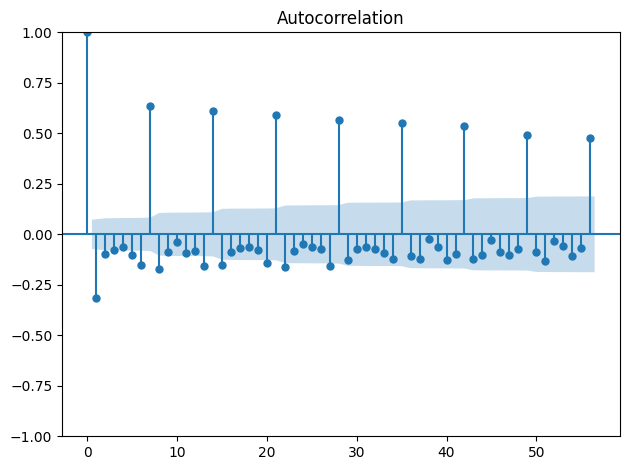

In [29]:
# 11
# Analisis de autocorrelación

# En terminos generales, este gráfico nos indica que un valor de cantidad esta
# directamente relacionado con su valor de cantidad anterior y su valor de cantidad de la semana pasada.
# Parece que hay estacionalidad semanal.

plot_acf(group["cantidad_diff"],lags=56)
plt.tight_layout()
plt.show()

In [30]:
# 12

# Semana y mes del año
df["weekofyear"] = df["fecha_venta"].dt.isocalendar().week
df["monthofyear"] = df["fecha_venta"].dt.month

# Día de la semana, del mes y del año
df["dayofweek"] = df["fecha_venta"].dt.dayofweek #Lunes 0 y Domingo 6
df["dayofmonth"] = df["fecha_venta"].dt.day
df["dayofyear"] = df["fecha_venta"].dt.dayofyear

def graph_by_freq(freq, breakdown="familia", norm=False):
    group = df.groupby([breakdown, freq], as_index=False)["cantidad"].sum()

    if norm == True:
        group['cantidad'] = group.groupby(breakdown)['cantidad'].transform(normalize)

    fig = px.line(group, x=freq, y="cantidad", color=breakdown, markers=True)
    fig.show()

# A nivel familia
graph_by_freq("dayofweek")

# Como nos encontramos en nuestro análisis de autocorrelación,
# los valores de cantidad podrían tener una relación con su valor de la semana pasada
# debido a que hay un patrón de compra semanal que se repite en el tiempo.

In [31]:
# 12

# A nivel articulo
graph_by_freq("dayofweek", "articulo")

In [32]:
# 12
# Gráficos caja

fig = px.box(df, x="dayofweek", y="cantidad", color='familia')
fig.show()

In [33]:
graph_by_freq("monthofyear")

*****

#### 4.3. Análisis de la variable a predecir frente al resto de variables

**Grupo de preguntas 5** (x minutos):

13. ¿El comportamiento de compra (la variable "cantidad") cuando es festivo es superior a cuando no lo es?

14. ¿El comportamiento de compra (la variable "cantidad") cuando llueve es superior a cuando no llueve?

15. Divide la variable "tavg_w" en quintiles y muestra con un gráfico de barras sí la variable "cantidad" es superior en alguno de sus quintiles.

In [34]:
# 13

# 1 si es festivo, 0 si no lo es
df['es_festivo'] = df['festivo'].apply(lambda x: 0 if x is None else 1)

fig = px.box(df, x="es_festivo", y="cantidad", color='familia')
fig.show()

# El comportamiento de compra cuando es festivo parece ligeramente superior

In [35]:
# 14

# 1 si llueve, 0 si no llueve
df["lluvia"] = np.where(df["prcp_w"].fillna(0) > 0, 1, 0)

fig = px.box(df, x="lluvia", y="cantidad", color='familia')
fig.show()

# Parece que la lluvia no es un impedimento para comprar

In [36]:
# 15

labels_tavg = ['Temperatura muy baja',
               'Temperatura baja',
               'Temperatura normal',
               'Temperatura alta',
               'Temperatura muy alta']

df['quintiles_tavg_w'] = pd.qcut(df['tavg_w'], q=5, labels=labels_tavg)

group = df.groupby(["familia", "quintiles_tavg_w"])["cantidad"].sum().reset_index()
fig = px.bar(group, x='quintiles_tavg_w', y='cantidad', color="familia",barmode='group')
fig.show()

/tmp/ipykernel_9480/2954901706.py:11: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**Grupo de preguntas 6** (x minutos):

16. ¿Un incremento en el precio reduce la propensión a consumir de un artículo?

In [37]:
# 16

def function_variations(x):
    list_unique = x.unique()
    len_list = len(list_unique)

    if len_list > 1:
        return 1
    else:
        return 0

group = df.groupby(["articulo",
                    pd.Grouper(key="fecha_venta", freq="1M"),
                    "familia"]).agg({"cantidad": "sum",
                                     "precio": function_variations}).reset_index()

group["precio"] = group.groupby("articulo")["precio"].transform("cumsum")
group["precio"] = group["precio"].astype(object)

fig = px.box(group, x="precio", y="cantidad", color='articulo')
fig.show()

# No es concluyente debido a que puede haber una tendencia negativa/positiva en el consumo general del articulo
# a lo largo del tiempo, pero es interesante observar como muchas veces si que tiene un impacto negativo
# (productos: 417, 1043, 1084, 3960, 5403).
# Podría ser también por la canibalización de nuevos productos a otros anteriores.

/tmp/ipykernel_9480/2320644404.py:13: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



*****